# Solving a one-asset HANK model in sequence space
In this notebook we show how to
1. [Adapt general HA blocks to specific models](#1-hetblock)
2. [Solve for a steady state with multiple calibration targets](#2-calibration)
3. [Compute linearized impulse responses: unwrap convenience function](#3-linear)
4. [Compute nonlinear impulse responses: quasi-Newton performs well even for large nonlinearities](#4-nonlinear)

This notebook accompanies the working paper by Auclert, Bardóczy, Rognlie, Straub (2019): "Using the Sequence-Space Jacobian to Solve and Estimate Heterogeneous-Agent Models". Please see the [Github repository](https://github.com/shade-econ/sequence-jacobian) for more information and code.


The model is a HA version of the textbook New Keynesian model. Technology is linear in labor, prices are sticky á la Rotemberg, and monetary policy follows a Taylor rule. For a detailed description of the model, please see the paper. As a reminder, the model can be summarized in sequence form as

$$
\textbf{H}_t(\textbf{Y}, Z) \equiv 
\begin{pmatrix}
Y_t - Z_t L_t
\\
Y_t \left[1 - \frac{\mu}{\mu-1}\frac{1}{2\kappa} \log(1 + \pi_t)^2\right] - w_t L_t - d_t
\\
r_t B - \tau_t
\\
r^*_t + \phi \pi_t - i_t
\\
1 + r_t - \frac{1+i_{t-1}}{1+\pi_t}
\\
\kappa \left(\frac{w_t}{Z_t} - \frac{1}{\mu} \right)  + \frac{1}{1+r_{t+1}} \frac{Y_{t+1}}{Y_t} \log(1+\pi_{t+1}) - \log(1+\pi_t)
\\
\mathcal{A}_t(\{r_s, w_s, \tau_s, d_s\})  - B
\\
\mathcal{N}_t(\{r_s, w_s, \tau_s, d_s\}) - L_t
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\end{pmatrix},
\qquad t = 0, 1, \dots
$$

where the endogenous variables are $\textbf{Y} = (Y, L, r, w, d, \pi, \tau, i)$ and the exogenous variables are $\textbf{Z}=(r^*, Z)$. 

The asset demand and labor supply functions $\{\mathcal{A}, \mathcal{L}\}$ follow from the household block with Bellman equation

$$
\begin{align} \tag{HH}
V_t(e, a_{-}) = \max_{c, n, a} &\left\{\frac{c^{1-\sigma}}{1-\sigma} - \varphi \frac{n^{1+\nu}}{1+\nu} + \beta \sum_{e'}V_{t+1}(e', a) \mathcal{P}(e,e') \right\}
\\
c + a &= (1 + r_t)a_{-} + w_t e n - \tau_t \bar{\tau}(e) + d_t \bar{d}(e)
\\
a &\geq 0
\end{align}
$$

where $\bar\tau(e)$ and $\bar d(e)$ are skill-specific incidence rules for taxes and dividends. 

We can think of the model as a directed acyclical graph (DAG) with **3 endogenous inputs**

![Directed Acyclical Graph](../figures/hank1_dag.png) 

and write it as an implicit function

$$
H(\pi, Y, w; \epsilon, Z) = 0.
$$

## 0 Import packages
The first two are standard python packages, the rest contain code we wrote for this project.

In [1]:
# Add the relative path to the top-level of the "sequence-jacobian" folder
# to be able to access the sequence_jacobian module
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt

from sequence_jacobian import simple, het, create_model
from sequence_jacobian.models import hank

<a id="1-hetblock"></a>

## 1 Adapting HA blocks with hetinput attachments

As we have seen in the Krusell-Smith notebook, the main task in setting up HA blocks is to write a backward iteration function that represents the Bellman equation. This has to be a single step of an iterative solution method such as value function iteration. For the standard income fluctuation problem with endogenous labor supply we're dealing with here, the endogenous gridpoint method of [Carroll (2006)](https://www.sciencedirect.com/science/article/pii/S0165176505003368) is the best practice.

Solving the endogenous-labor problem via EGM is standard but somewhat tedious and so the details are left to ``hank.py``. Instead we will focus on a new feature that makes it much easier to adapt HetBlocks to different macro enviroments.

The backward iteration function `hank.household` corresponds to the general problem:

$$
\begin{align} \tag{HH-general}
V_t(e, a_{-}) = \max_{c, n, a} &\left\{\frac{c^{1-\sigma}}{1-\sigma} - \varphi \frac{n^{1+\nu}}{1+\nu} + \beta \sum_{e'}V_{t+1}(e', a) \mathcal{P}(e,e') \right\}
\\
c + a &= (1 + r_t)a_{-} + w_t e n + T_t(e)
\\
a &\geq 0
\end{align}
$$

That is, households take as given the sequence of interest rates $r_t$, wages $w_t$ and skill-specific transfers $T_t(e).$ In the context of this particular HANK model, transfers equal dividends minus taxes. But it's easy to imagine many other cases. Rather than writing a specific backward iteration function for each of them, we can just supply a function that specifies how the $\{r_t, w_t, T_t(e)\}$ are determined in this particular case. We refer such functions as **hetinput**. 


Since $r_t$ and $w_t$ correspond directly to aggregate variables of the model, we only have to specify transfers:

In [2]:
def transfers(pi_e, Div, Tax, e_grid):
    # default incidence rules are proportional to skill
    tax_rule, div_rule = e_grid, e_grid  # scale does not matter, will be normalized anyway

    div = Div / np.sum(pi_e * div_rule) * div_rule
    tax = Tax / np.sum(pi_e * tax_rule) * tax_rule
    T = div - tax
    return T

Let's attach this hetinput function to the household HetBlock using (the aptly-named) ``HetBlock.add_hetinput`` method.

*Note that we are setting `overwrite=True`, since we provide the above transfer rule as the default one in the `sj.hank.household` HetBlock.

In [3]:
household = hank.household
household.add_hetinput(transfers, overwrite=True, verbose=False)

Each HetBlock can be associated with at most one hetinput (hence the need to overwrite, as indicated above). Once it is added, every call to the HetBlock will be routed through the hetinput function first.

<a id="2-calibration"></a>

## 2 Calibrating the steady state
Similarly to the RBC example, we calibrate the discount factor $\beta$ and disutility of labor $\varphi$ to hit a target for the interest rate and effective labor $L=1.$ Additionally we calibrate the wage $w$ such that the Phillips curve relation is satisfied in steady state.

In [14]:
blocks = [household, hank.firm, hank.monetary, hank.fiscal, hank.mkt_clearing, hank.nkpc,
          hank.income_state_vars, hank.asset_state_vars]
hank_model = create_model(blocks, name="One Asset HANK")

calibration = {"r": 0.005, "rstar": 0.005, "eis": 0.5, "frisch": 0.5, "B_Y": 5.6, "B": 5.6, "mu": 1.2,
               "rho_s": 0.966, "sigma_s": 0.5, "kappa": 0.1, "phi": 1.5, "Y": 1, "Z": 1, "L": 1,
               "pi": 0, "nS": 7, "amax": 150, "nA": 500}
unknowns_ss = {"beta": 0.986, "vphi": 0.8, "w": 0.8}
targets_ss = {"asset_mkt": 0, "labor_mkt": 0, "nkpc_res": 0.}

ss = hank_model.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")

Let's solve for the steady state using our default calibration, and plot the labor supply policy as function of assets for each skill type. In general, poorer and more productive households choose to work more. 

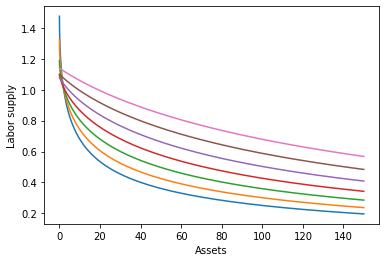

In [15]:
plt.plot(ss['a_grid'], ss.internal["household"]['n'].T)
plt.xlabel('Assets'), plt.ylabel('Labor supply')
plt.show()

<a id="3-linear"></a>

## 3 Linearized dynamics using Jacobians
Recall that we reduced the to the following DAG:

![Directed Acyclical Graph](../figures/hank1_dag.png) 

that can also be written as an implicit equation

$$
H(\pi, Y, w; r^*, Z) =
\begin{pmatrix}
\kappa \left(\frac{w_t}{Z_t} - \frac{1}{\mu} \right)  + \frac{1}{1+r_{t+1}} \frac{Y_{t+1}}{Y_t} \log(1+\pi_{t+1}) - \log(1+\pi_t)
\\
\mathcal{A}_t(\{r_s, w_s, \tau_s, d_s\})  - B
\\
\mathcal{L}_t(\{r_s, w_s, \tau_s, d_s\}) - L_t
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0\end{pmatrix},
$$

to be solved for $U=(\pi, w, Y)$ given any $Z=(Z, r^*)$. The rest of the endogenous variables are be obtained as explicit functions of $(\pi, w, Y; Z, r^*)$ along the DAG, but it would be tedious to write them out.

Keep in mind that the implicit function theorem implies that the response of unknowns is

$$
dU = \underbrace{-H_U^{-1}H_Z}_{G_U} dZ \tag{1}
$$

Recall that we already solved for a steady state and stored is as `ss`. Furthermore, we will use a 300-period truncation horizon. 

### 3.1 Cut to the chase
The recommended way to obtain the general equilibrium Jacobians is to use the `solve_jacobian` method for the `hank_model` object.

In [6]:
# setup
T = 300
exogenous = ['rstar', 'Z']
unknowns = ['pi', 'w', 'Y']
targets = ['nkpc_res', 'asset_mkt', 'labor_mkt']

# general equilibrium jacobians
G = hank_model.solve_jacobian(ss, exogenous, unknowns, targets, T=T)

### 3.2 Break down `solve_jacobian`

Under the hood, the `solve_jacobian` method performs the following steps:
 - orders the blocks so that we move forward along the model's DAG
 - computes the partial Jacobians $\mathcal{J}^{o,i}$ from all blocks (if their Jacobian is not supplied already), only with respect to the inputs that actually change: unknowns, exogenous shocks, outputs of earlier blocks
 - forward accumulates partial Jacobians $\mathcal{J}^{o,i}$ to form total Jacobians $\mathbf{J}^{o,i}$
 - packs $\mathbf{J}^{o,i}$ to form $\mathbf{H_U}$ and $\mathbf{H_Z}$
 - solves for the GE Jacobians for unknowns $\mathbf{G_U} = \mathbf{H_U}^{-1}\mathbf{H_Z}$
 - forward accumulates GE Jacobians to obtain $\mathbf{G}$ for other endogenous variables 
 
Let's take a closer look at each.

#### Step 1: Topological sort and partial Jacobians
By looking at the inputs and outputs of each block, we can order them so that we only move forward on the DAG (this is called a **topological sort**). Knowing the DAG is a prerequisite for all that follows, and also allows us to avoid wasteful Jacobian calculations: we only need Jacobians with respect to unknowns, exogenous, and outputs of earlier blocks.

In [7]:
import sequence_jacobian.jacobian.drivers as jacobian
from sequence_jacobian.jacobian.classes import JacobianDict

curlyJs, required = jacobian.curlyJ_sorted(blocks, unknowns + exogenous, ss, T)

The first output `curlyJs` is a list of `JacobianDict` objects. Each `JacobianDict` contains all the necessary Jacobians for the corresponding block. Blocks are ordered according to the topological sort.

For example, the first block is `monetary`, because it only takes an unknown $\pi$ and an exogenous $r^*$ as inputs. Let's take a look. 

In [8]:
print(f"The JacobianDict for the monetary block is: {curlyJs[0]}")

The JacobianDict for the monetary block is: <JacobianDict outputs=['r'], inputs=['rstar', 'pi']>


Note that `curlyJ_sorted` correctly determined that it is not necessary to differentiate with respect to the Taylor rule parameter $\phi$ (if we wanted to consider shocks to this parameter, we'd just have to include it among the exogenous inputs.)

The second output `required` is a set of extra variables (not unknowns and exogenous) that we have to differentiate with respect to, because they are outputs of some blocks and inputs of others. 

In [9]:
print(required)

{'A', 'C', 'N_e', 'r', 'Div', 'L', 'Tax'}


#### Step 2: Compose Jacobians along the DAG
We're interested in the Jacobians with respect to the inputs of $H$, i.e. the unknowns $(\pi, w, Y)$ and the shocks $(r^*, Z).$  

First, we apply the chain rule by using `jac.forward_accumulate`. This gives the $T \times T$ building blocks of the $H_U$ and $H_Z$ that relate targets to unknowns and exogenous. 

In [10]:
J_curlyH_U = jacobian.forward_accumulate(curlyJs, unknowns, targets, required)
J_curlyH_Z = jacobian.forward_accumulate(curlyJs, exogenous, targets, required)

Next, we just have to pack them into two (big) matrices. These capture (to first order) the implicit relationship between unknowns $X=(\pi, w, Y)$ induced by the requirement that markets clear and the Phillips curve holds, i.e. that the targets of the DAG evaluate to zero.

In [11]:
H_U = J_curlyH_U[targets, unknowns].pack(T)
H_Z = J_curlyH_Z[targets, exogenous].pack(T)
print(H_U.shape)
print(H_Z.shape)

(900, 900)
(900, 600)


#### Step 3: General equilibrium Jacobians
First we can get the response of unknowns directly by the implicit function theorem.

In [17]:
G_U = JacobianDict.unpack(-np.linalg.solve(H_U, H_Z), unknowns, exogenous, T)

And the rest can be obtained by forward accumulation that accounts for the direct and indirect effects alike.

In [18]:
curlyJs_aug = [G_U] + curlyJs
outputs = set().union(*(curlyJ.outputs for curlyJ in curlyJs_aug)) - set(targets)

G2 = jacobian.forward_accumulate(curlyJs_aug, exogenous, outputs, required | set(unknowns))

### 3.3 Results
First let's check that we have correctly reconstructed the steps of `jac.get_G`.

In [19]:
for o in G:
    for i in G[o]:
        assert np.allclose(G[o][i], G2[o][i])

Now let's consider 25 basis point monetary policy shocks with different persistences and plot the response of inflation.

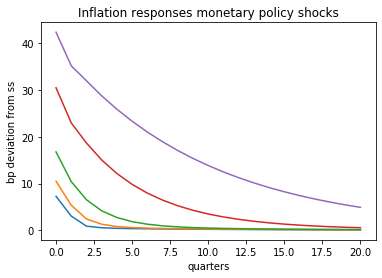

In [20]:
rhos = np.array([0.2, 0.4, 0.6, 0.8, 0.9])

drstar = -0.0025 * rhos ** (np.arange(T)[:, np.newaxis])
dpi = G['pi']['rstar'] @ drstar

plt.plot(10000 * dpi[:21])
plt.title(r'Inflation responses monetary policy shocks')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.show()

<a id="4-nonlinear"></a>

## 4. Nonlinear dynamics
Conceptually there's nothing new in this section compared to the Krusell-Smith notebook. We're going to implement a quasi-Newton algorithm to solve for the unknown sequences $U=(\pi, w, Y)$ given some sequences of shocks $(r^*, Z).$ We initialize the algorithm by the naive guess that the variables in $U$ stay constant at their steady-state level. Then we evaluate the DAG and update the guess using the inverse Jacobian $H_U^{-1}.$ The algorithm converges in a few steps, despite the presence of substantial nonlinearities.

### 4.1 A typical monetary policy shock
Note that the linearized solution ignores price adjustment costs. For a monetary policy shock of typical size and persistence, this does not really matter.   

On iteration 0
   max error for nkpc_res is 0.00E+00
   max error for asset_mkt is 1.46E-02
   max error for labor_mkt is 2.73E-03
On iteration 1
   max error for nkpc_res is 1.16E-06
   max error for asset_mkt is 1.33E-04
   max error for labor_mkt is 6.89E-06
On iteration 2
   max error for nkpc_res is 4.81E-08
   max error for asset_mkt is 2.21E-06
   max error for labor_mkt is 1.42E-07
On iteration 3
   max error for nkpc_res is 1.26E-09
   max error for asset_mkt is 3.46E-08
   max error for labor_mkt is 8.41E-10
On iteration 4
   max error for nkpc_res is 2.10E-11
   max error for asset_mkt is 5.01E-10
   max error for labor_mkt is 1.26E-11


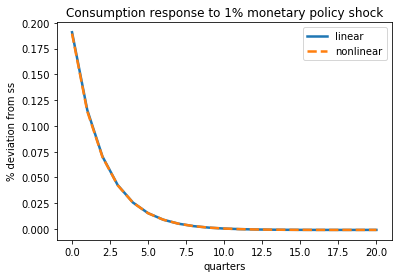

In [25]:
rho_r, sig_r = 0.61, -0.01/4
rstar_shock_path = {"rstar": sig_r * rho_r ** (np.arange(T))}

td_nonlin = hank_model.solve_impulse_nonlinear(ss, rstar_shock_path, unknowns, targets)
td_lin = hank_model.solve_impulse_linear(ss, rstar_shock_path, unknowns, targets)

dC_nonlin = 100 * td_nonlin.deviations().normalize()["C"]
dC_lin = 100 * td_lin.normalize()["C"]

plt.plot(dC_lin[:21], label='linear', linestyle='-', linewidth=2.5)
plt.plot(dC_nonlin[:21], label='nonlinear', linestyle='--', linewidth=2.5)
plt.title(r'Consumption response to 1% monetary policy shock')
plt.xlabel('quarters')
plt.ylabel('% deviation from ss')
plt.legend()
plt.show()

### 4.2 A very large monetary policy shock
However, the nonlinearities may become substantial for very large or persistent monetary policy shocks. Reassuringly, the Jacobian still works well as an updating rule. The quasi-Newton method for a 10% monetary policy shock (extremely large!) still converges below in just 9 iterations, despite nonlinearities evident in the results.

On iteration 0
   max error for nkpc_res is 0.00E+00
   max error for asset_mkt is 1.41E-01
   max error for labor_mkt is 2.68E-02
On iteration 1
   max error for nkpc_res is 9.66E-05
   max error for asset_mkt is 1.30E-02
   max error for labor_mkt is 5.55E-04
On iteration 2
   max error for nkpc_res is 2.62E-05
   max error for asset_mkt is 2.19E-03
   max error for labor_mkt is 7.31E-04
On iteration 3
   max error for nkpc_res is 3.84E-06
   max error for asset_mkt is 3.80E-04
   max error for labor_mkt is 9.03E-05
On iteration 4
   max error for nkpc_res is 1.50E-06
   max error for asset_mkt is 6.39E-05
   max error for labor_mkt is 1.83E-05
On iteration 5
   max error for nkpc_res is 1.26E-07
   max error for asset_mkt is 1.05E-05
   max error for labor_mkt is 2.52E-06
On iteration 6
   max error for nkpc_res is 3.47E-08
   max error for asset_mkt is 1.72E-06
   max error for labor_mkt is 4.66E-07
On iteration 7
   max error for nkpc_res is 3.43E-09
   max error for asset_mkt is 

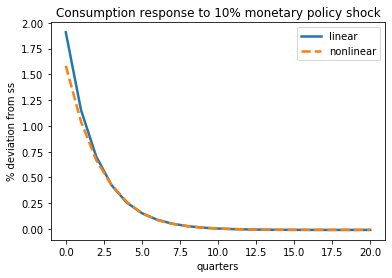

In [26]:
rho_r, sig_r = 0.61, -0.10/4
rstar_shock_path = {"rstar": sig_r * rho_r ** (np.arange(T))}

td_nonlin = hank_model.solve_impulse_nonlinear(ss, rstar_shock_path, unknowns, targets)
td_lin = hank_model.solve_impulse_linear(ss, rstar_shock_path, unknowns, targets)

dC_nonlin = 100 * td_nonlin.deviations().normalize()["C"]
dC_lin = 100 * td_lin.normalize()["C"]

plt.plot(dC_lin[:21], label='linear', linestyle='-', linewidth=2.5)
plt.plot(dC_nonlin[:21], label='nonlinear', linestyle='--', linewidth=2.5)
plt.title(r'Consumption response to 10% monetary policy shock')
plt.xlabel('quarters')
plt.ylabel('% deviation from ss')
plt.legend()
plt.show()